In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%load_ext Cython
pd.options.display.max_columns = 999

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_squared_error
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from tqdm import tqdm_notebook

from sklearn import metrics

import requests as requests
import json as json
import lendingclub.account_info as acc_info
import re as re
from sklearn.externals import joblib
import lendingclub.dataprep_and_modeling.modeling_utils.data_prep_new as data_prep
import lendingclub.investing.investing_utils as investing_utils
import pandas as pd
import numpy as np
import math as math
from  lendingclub.dataprep_and_modeling.model_dump.nn_1_0_0 import net_class
import torch

In [3]:
def applyEndD(status, group, max_date):
    # end_d to me means the date we can stop tracking things about the loan. Should be defunct
    if status in ['Charged Off', 'Default']:
        #split the group into two groups, one which has paid something, and other which has paid nothing
        never_paid = group[group['last_pymnt_d'].isnull()]
        has_paid = group[group['last_pymnt_d'].notnull()]

        never_paid['end_d'] = never_paid['issue_d'] + pd.DateOffset(months=+5)
        has_paid['end_d'] = has_paid['last_pymnt_d'] + pd.DateOffset(months=+5)

        group.ix[never_paid.index.values, 'end_d'] = never_paid['end_d']
        group.ix[has_paid.index.values, 'end_d'] = has_paid['end_d']
        return group['end_d']
    elif status == 'Fully Paid':
        return group['last_pymnt_d']
    else:
        return pd.Series([max_date] * len(group), index=group.index.values)

def add_dateparts(df):
    '''Uses the fastai add_datepart to turn datetimes into numbers to process
       does not do it for issue_d'''
    date_cols = df.select_dtypes(['datetime64']).columns
    for date_col in date_cols:
        if date_col not in special_cols:
            add_datepart(df, date_col, drop=True)
    return [col for col in date_cols if col not in special_cols]

def drop_cols_for_scaling(df):
    '''Since some data fields were added later, some datasets when checking do not
       have any varation. Drop those cols'''
    drop_cols = []
    for col in df.columns:
        if (len(df[col].value_counts(dropna=False)) <= 1):# & (col != 'term'):
            drop_cols.append(col)
    df.drop(drop_cols, axis=1, inplace=True)
    return drop_cols

class StandardScalerJustin(TransformerMixin, BaseEstimator):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.copy = copy
    
    def fit(self, X, y=None):
        if type(X) == np.ndarray:
            X = pd.Series(X.reshape(-1))
        self.mean_ = X.dropna().mean()
        self.var_ = X.dropna().var()
        return self

    def transform(self, X):
        mean = self.mean_
        std_dev = np.sqrt(self.var_)
        if std_dev == 0:
            return X
        return (X-mean)/std_dev
    
def fit_scalers(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScalerJustin()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    return mapper    

def proc_df_justin(df, y_fld, valid_test, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None, train_cols_meds=None, cols=None):

    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable
    
    valid_test: boolean indicating if this is a df to match to train columns.

    skip_flds: A list of fields that dropped from df.

    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time(mean and standard deviation).
        
    train_cols_meds: dict where keys are columns from training and values are medians, use for values to fill an entire missing column (shouldn't be needed when used to actually pick loans, was needed for train/valid/test due to new fields being added over the timeframe and missing in certain datasets while existing in others)
    
    cols: Just to compare column order and ensure the variables are in the right order.

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time."""        
    assert type(valid_test) == bool, print('must indiciate if this is test/valid set to match columns with train')
    
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    # fit the scalers
    if do_scale: mapper = fit_scalers(df, mapper)
    if na_dict is None: na_dict = {}      
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    df[mapper.transformed_names_] = mapper.transform(df)
    embeddings=[]
    for n,c in df.items():
        numericalize(df, c, n, max_n_cat)
        if not is_numeric_dtype(c):
            embeddings.append(prep_embeddings(c, n))
    df = pd.get_dummies(df, dummy_na=True)
    # fix the nas
    if valid_test:
        for col, med in train_cols_meds.items():
            try:
                df[col].fillna(med, inplace=True)
            except KeyError:
                df[col] = med
        df = df[cols]
        
    res = [df, y, na_dict, embeddings]
    if not valid_test: res += [res[0].median(), res[0].columns]
    if do_scale: res = res + [mapper]
    return res

def prep_embeddings(c, n):
    # allocate in embeddings for a null
    return (n, len(c.cat.categories)+1)

def eval_models(trials, port_size, available_loans, regr_version, X_test, y_test,
                default_series, yhat_test): #regr, 
    results = {}
    pct_default = {}
    test_copy = X_test.copy()
    
    default_series = default_series.loc[X_test.index]
    yhats_ys_defs = pd.DataFrame([yhat_test, y_test, default_series.values]).T
    yhats_ys_defs.rename(columns={0:'yhat', 1:'y', 2:'defaults'}, inplace=True)
    for trial in tqdm_notebook(np.arange(trials)):
        # of all test loans, grab a batch of n=available_loans
        available_idx = np.random.choice(
            np.arange(len(test_copy)), available_loans, replace=False)
        available_loans_df = yhats_ys_defs.ix[available_idx,:]
        available_loans_df.sort_values('yhat', inplace=True, ascending=False)
        picks = available_loans_df[:port_size]
        results[trial] = picks['y'].mean()
        pct_default[trial] = picks['defaults'].sum()/port_size
    pct_default_series = pd.Series(pct_default)
    results_df = pd.DataFrame(pd.Series(results))
    results_df['pct_def'] = pct_default_series
    results_df.columns = pd.MultiIndex(levels=[[regr_version], [0.07, 'pct_def']],
           labels=[[0, 0,], [0, 1,]],
           names=['discount_rate', 'model'])
    return results_df

In [4]:
%%cython
cimport numpy as np
import numpy as np

cpdef rem_to_be_paid(double out_prncp,
                     double install,
                     double int_rate):
    cdef double m_rate
    cdef double to_be_paid
    m_rate = int_rate/(100*12)
    to_be_paid = 0.0
    k = 0
    while out_prncp > 0:
        k += 1
        out_prncp = (1+m_rate) * out_prncp
        out_prncp -= install
        to_be_paid += install
        # the break was added to figure out what was wrong with infinite while; it was due to installment funded
        # being INCORRECTLY REPORTED by lending club
        if k >= 100:
            print(to_be_paid)
            break
        if out_prncp < 0:
            to_be_paid -= abs(out_prncp)
    return to_be_paid

cpdef np.ndarray[double] apply_rem_to_be_paid(np.ndarray col_out_prncp,
                                              np.ndarray col_install,
                                              np.ndarray col_int_rate):
#     assert (col_out_prncp.dtype == np.float and col_install.dtype == np.float and col_int_rate.dtype == np.float), print(col_out_prncp.dtype, np.float32)
    cdef Py_ssize_t i, n = len(col_out_prncp)
    assert (len(col_out_prncp) == len(col_install) == n)
    cdef np.ndarray[double] res = np.empty(n)
    for i in xrange(n):
        res[i] = rem_to_be_paid(col_out_prncp[i],
                                col_install[i],
                                col_int_rate[i])
    return res

In [5]:
# setup of constants, dirs, stores.
platform = 'lendingclub'
lcpath = f'{datapath}{platform}/'
RFpath = f'{lcpath}RF/'
NNpath = f'{lcpath}NN/'
storepath = f'{lcpath}{platform}.h5'
token = acc_info.token
inv_acc_id = acc_info.investor_id
portfolio_id = acc_info.portfolio_id
header = {
    'Authorization': token,
    'Content-Type': 'application/json',
    'X-LC-LISTING-VERSION': '1.3'
}
os.makedirs(RFpath, exist_ok=True)
os.makedirs(NNpath, exist_ok=True)
store = pd.HDFStore(storepath)
store.close()

In [16]:
store.open()
raw_loan_info = store['loan_info_merged']
ys = store['loan_npv_rois']
model_results = store['model_results']
default_series = store['default_series']
store.close()
# since everything will basically be id dependent, ensure that there are no dupe ids
assert len(raw_loan_info[raw_loan_info.duplicated('id')]['id']) == 0

# load in raw data, do minimal processing to segment into train/valid/test

In [7]:
store.open()
raw_loan_info = store['loan_info_merged']
ys = store['loan_npv_rois']
model_results = store['model_results']
store.close()
# since everything will basically be id dependent, ensure that there are no dupe ids
assert len(raw_loan_info[raw_loan_info.duplicated('id')]['id']) == 0

In [8]:
# turn all date columns into pandas timestamp ________________________________
month_dict = {
    'jan': '1',
    'feb': '2',
    'mar': '3',
    'apr': '4',
    'may': '5',
    'jun': '6',
    'jul': '7',
    'aug': '8',
    'sep': '9',
    'oct': '10',
    'nov': '11',
    'dec': '12'
}
date_cols = ['earliest_cr_line',
             'sec_app_earliest_cr_line', 'issue_d', 'last_pymnt_d']

for col in date_cols:
    raw_loan_info[col] = raw_loan_info[col].str.lower()
    raw_loan_info[col] = pd.to_datetime(
        raw_loan_info[col].str[:3].str.lower().replace(month_dict) +
        raw_loan_info[col].str[3:],
        format='%m-%Y')

# determining loan end_d _____________________________________________________
# clean loan_status
raw_loan_info['loan_status'] = raw_loan_info['loan_status'].apply(
    lambda x: re.sub('Does not meet the credit policy. Status:', '', x))

status_grouped = raw_loan_info.groupby('loan_status')
max_date = raw_loan_info['last_pymnt_d'].max()
end_d_series = pd.Series([])
for status, group in tqdm_notebook(status_grouped):
    end_d_series = end_d_series.append(
        applyEndD(status, group, max_date), verify_integrity=True)

raw_loan_info['end_d'] = end_d_series

# maturity_time ______________________________________________________________
raw_loan_info['months_paid'] = ((
    max_date - raw_loan_info['issue_d']) / np.timedelta64(1, 'D') *
    (12 / 365.25)).round()
raw_loan_info['maturity_time'] = raw_loan_info['months_paid'] / \
    raw_loan_info['term']
raw_loan_info['maturity_time'] = np.where(raw_loan_info['maturity_time'] >= 1, 1,
                                          raw_loan_info['maturity_time'])

# maturity paid ______________________________________________________________
raw_loan_info['rem_to_be_paid'] = apply_rem_to_be_paid(
    raw_loan_info['out_prncp'].values, raw_loan_info['installment'].values,
    raw_loan_info['int_rate'].values)
raw_loan_info['maturity_paid'] = raw_loan_info['total_pymnt'] / (
    raw_loan_info['total_pymnt'] + raw_loan_info['rem_to_be_paid'])
# mat_paid has nans because some charged_off loans have 0 rem_to_be_paid
# which is inconsistent with the majority treatment. quick fix is fillna
raw_loan_info['maturity_paid'] = raw_loan_info['maturity_paid'].fillna(0)

# target_loose (defaulted/charged_off or not)
raw_loan_info['target_loose'] = np.where(
    raw_loan_info['loan_status'].isin(['Default', 'Charged Off']), 1, 0)

# get index for all_train now, which are done and almost done loans
done_statuses = ['Charged Off', 'Fully Paid', 'Default']
all_train_index = raw_loan_info[(raw_loan_info['loan_status'].isin(done_statuses)) | (raw_loan_info['maturity_paid'] > .9)]['id']

A Jupyter Widget

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.h

# See what fields I can get through API

In [9]:
api_loans, api_ids = investing_utils.get_loans_and_ids(header, exclude_already=True)
api_columns = api_loans.columns
find_matching_col_manually = []
already_matching_api_csv = []
for col in api_columns:
    try:
        raw_loan_info[col]
        already_matching_api_csv.append(col)
    except KeyError:
        find_matching_col_manually.append(col)
        
api_to_loan_info_dict = {'acc_open_past_24_mths': 'acc_open_past_24mths',
                         'addr_zip': 'zip_code', 
                         'delinq_2_yrs': 'delinq_2yrs',
                         'i_l_util': 'il_util',
                         'inq_last_6_mths': 'inq_last_6mths',
                         'is_inc_v': 'verification_status',
                         'is_inc_v_joint': 'verification_status_joint',
                         'loan_amount': 'loan_amnt',
                         'num_accts_ever_12_0_ppd':'num_accts_ever_120_pd',
                         'num_tl_12_0dpd_2m':'num_tl_120dpd_2m',
                         'sec_app_inq_last_6_mths':'sec_app_inq_last_6mths'}
loan_info_to_api_dict = {v:k for k,v in api_to_loan_info_dict.items()}

# rename loan_info columns to api names
raw_loan_info.rename(columns=loan_info_to_api_dict, inplace=True)

In [10]:
set_api = set(api_columns)
set_raw_loan_info = set(raw_loan_info.columns)
overlapping_cols = list(set_api.intersection(set_raw_loan_info))
overlapping_cols.sort()

# notes: leaving id in since it is needed to keep track of loans,
# api_loans installment differes from loan installment if loan wasn't fully funded so remake the col "installment_funded"
# 
not_use_cols = ['member_id']
use_cols = [col for col in overlapping_cols if col not in not_use_cols]
special_cols = ['issue_d', 'maturity_time', 'maturity_paid', 'end_d', 'target_loose']

In [11]:
loan_info = raw_loan_info[use_cols + special_cols]
api_loans_use = api_loans[use_cols]

In [12]:
# change loan_info values to api_loan_use values
application_type_dict = {'Joint App': 'JOINT',
                         'Individual': 'INDIVIDUAL'}
loan_info['application_type'].replace(application_type_dict, inplace=True)

disbursement_method_dict = {'DirectPay': 'DIRECT_PAY',
                         'Cash': 'CASH'}
loan_info['disbursement_method'].replace(disbursement_method_dict, inplace=True)

emp_length_dict = {'< 1 year':0,
                   '1 year':12,
                   '2 years':24,
                   '3 years':36,
                   '4 years':48,
                   '5 years':60,
                   '6 years':72,
                   '7 years':84,
                   '8 years':96,
                   '9 years':108,
                   '10+ years':120,}
loan_info['emp_length'].replace(emp_length_dict, inplace=True)

initial_list_status_dict = {'w': 'W',
                         'f': 'F'}
loan_info['initial_list_status'].replace(initial_list_status_dict, inplace=True)

is_inc_v_dict = {'Not Verified': 'NOT_VERIFIED',
                         'Verified': 'VERIFIED',
                        'Source Verified': 'SOURCE_VERIFIED',}
loan_info['is_inc_v'].replace(is_inc_v_dict, inplace=True)

is_inc_v_joint_dict = {'Not Verified': 'NOT_VERIFIED',
                         'Verified': 'VERIFIED',
                        'Source Verified': 'SOURCE_VERIFIED',}
loan_info['is_inc_v_joint'].replace(is_inc_v_joint_dict, inplace=True)

loan_info['revol_util'] = loan_info['revol_util'] * 100

loan_info['installment_old'] = loan_info['installment']
loan_info.drop('installment_old', axis=1, inplace=True)
loan_info['installment'] = np.pmt(loan_info['int_rate']/(100*12), loan_info['term'], -loan_info['loan_amount'])


# things to map properly to numbers in api_loans
things_to_map_in_api_loans = ['grade', 'home_ownership',]

# remake installment on loan info to be as if it were in funding so based on loan amount
# and not on actual funded amount

/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [13]:
# Save this as loan_info_step_1
loan_info.set_index('id', inplace=True)
default_series = loan_info['target_loose']

loan_info.to_hdf(store, key='loan_info_step1', format='table')
default_series.to_hdf(store, key='default_series')

# do the splitting on train/test/val

In [14]:
nearly_done = loan_info[(loan_info['maturity_paid'] > .9) & (loan_info['maturity_time'] > .9)]
# take last quarter of nearly done as test/valid, take all loans with end_d before first month of last quarter to train on
cutoff_issue_d = nearly_done['issue_d'].max() + pd.DateOffset(months=-3)
test_valid = nearly_done[nearly_done['issue_d'] >= cutoff_issue_d].index
train_index = nearly_done[nearly_done['end_d'] < cutoff_issue_d].index

In [15]:
test_index = np.random.choice(test_valid, int(len(test_valid)/2), replace=False)
valid_index = [ids for ids in test_valid if ids not in test_index]
assert len(set(test_index).intersection(set(valid_index))) == 0
assert len(set(test_index).intersection(set(train_index))) == 0
assert len(set(train_index).intersection(set(valid_index))) == 0

In [16]:
store.open()
store['test_index'] = pd.Series(test_index)
store['valid_index'] = pd.Series(valid_index)
store['train_index'] = pd.Series(train_index)
store['all_train_index'] = all_train_index
store.close()

# cut loan info to just columns for modeling, add dateparts

In [17]:
use_cols = [col for col in use_cols if col != 'id']
loan_info = loan_info[use_cols]
loan_info['y'] = ys

In [32]:
add_dateparts(loan_info)
loan_info.shape

(1646778, 127)

In [35]:
train_cats(loan_info)
loan_info.shape

(1646778, 127)

In [38]:
# reorder grade and subgrade
loan_info['grade'].cat.reorder_categories(sorted(loan_info['grade'].unique()), ordered=True, inplace=True)
loan_info['sub_grade'].cat.reorder_categories(sorted(loan_info['sub_grade'].unique()), ordered=True, inplace=True)

In [40]:
# ensure the categories are right, save them so that api categories are encoded correctly
col_cat_dict = {}
for col in loan_info.select_dtypes(['category']).columns:
    col_cat_dict[col] = loan_info[col].cat.categories

In [21]:
train = loan_info.loc[train_index,:]
valid = loan_info.loc[valid_index,:]
test = loan_info.loc[test_index,:]
all_train = loan_info.loc[all_train_index,:]

drop_cols_for_scaling(train)
drop_cols_for_scaling(valid)
drop_cols_for_scaling(test)

# train has more columns than valid, test. Fill with mode, sort columns to train.
for col in train.columns:
    if col not in valid.columns:
        valid[col] = train[col].mode()
    if col not in test.columns:
        test[col] = train[col].mode()
        
valid = valid[train.columns]
test = test[train.columns]
assert train.shape[1] == test.shape[1] == valid.shape[1]

store.open()
train.to_hdf(store, key='train', format='table')
test.to_hdf(store, key='test', format='table')
valid.to_hdf(store, key='valid', format='table')
all_train.to_hdf(store, key='all_train', format='table')
store.close()

In [42]:
train.head()

,acc_now_delinq,acc_open_past_24_mths,addr_state,addr_zip,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2_yrs,delinq_amnt,disbursement_method,dti,dti_joint,emp_length,fico_range_high,fico_range_low,grade,home_ownership,i_l_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6_mths,installment,int_rate,is_inc_v,is_inc_v_joint,loan_amount,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_12_0_ppd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_12_0dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6_mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,sub_grade,tax_liens,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,y,earliest_cr_lineYear,earliest_cr_lineMonth,earliest_cr_lineWeek,earliest_cr_lineDay,earliest_cr_lineDayofweek,earliest_cr_lineDayofyear,earliest_cr_lineIs_month_end,earliest_cr_lineIs_month_start,earliest_cr_lineIs_quarter_end,earliest_cr_lineIs_quarter_start,earliest_cr_lineIs_year_end,earliest_cr_lineIs_year_start,earliest_cr_lineElapsed,sec_app_earliest_cr_lineYear,sec_app_earliest_cr_lineMonth,sec_app_earliest_cr_lineWeek,sec_app_earliest_cr_lineDay,sec_app_earliest_cr_lineDayofweek,sec_app_earliest_cr_lineDayofyear,sec_app_earliest_cr_lineIs_month_end,sec_app_earliest_cr_lineIs_month_start,sec_app_earliest_cr_lineIs_quarter_end,sec_app_earliest_cr_lineIs_quarter_start,sec_app_earliest_cr_lineIs_year_end,sec_app_earliest_cr_lineIs_year_start,sec_app_earliest_cr_lineElapsed
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36805548,0.0,7.0,CA,937xx,NaN,58000.0,NaN,INDIVIDUAL,9536.0,7599.0,41.500000,0.0,0.0,0.0,0.0,NaN,14.920000,NaN,96.0,714.0,710.0,A,MORTGAGE,NaN,W,NaN,NaN,2.0,321.072130,6.99,NOT_VERIFIED,NaN,10400.0,NaN,76.0,290.0,1.0,1.0,1.0,42.0,59.0,NaN,NaN,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,83.300003,14.3,0.0,0.0,credit_card,6133.0,NaN,31.600002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A3,0.0,36.0,0.0,162110.0,179407.0,36.0,15030.0,NaN,13000.0,NaN,11325.0,19400.0,-0.410322,1989.0,9.0,35.0,1.0,4.0,244.0,False,True,False,False,False,False,620611200,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,-9223372037
38098114,0.0,5.0,VA,235xx,NaN,78000.0,NaN,INDIVIDUAL,29828.0,9525.0,4.700000,0.0,0.0,0.0,0.0,NaN,12.030000,NaN,120.0,754.0,750.0,C,RENT,NaN,W,NaN,NaN,0.0,336.631520,12.39,SOURCE_VERIFIED,NaN,15000.0,NaN,103.0,244.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.0,0.0,0.0,debt_consolidation,138008.0,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1,0.0,60.0,0.0,149140.0,196500.0,17.0,149140.0,NaN,10000.0,NaN,12000.0,184500.0,0.068541,1994.0,8.0,31.0,1.0,0.0,213.0,False,True,False,False,False,False,775699200,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,-9223372037
37822187,0.0,8.0,NJ,077xx,NaN,69000.0,NaN,INDIVIDUAL,3214.0,6494.0,69.199997,0.0,0.0,0.0,0.0,NaN,25.809999,NaN,120.0,684.0,6

In [45]:
train['application_type'].cat.categories

Index(['DIRECT_PAY', 'INDIVIDUAL', 'JOINT'], dtype='object')

In [47]:
X_train.shape

(753098, 220)

In [22]:
# X_train, y_train, nas_train, mean_stdev_mapper = proc_df(train, 'y', do_scale=True)
X_train, y_train, nas, embeddings, train_cols_meds, cols, mean_stdev_mapper = proc_df_justin(train, 'y', valid_test = False, do_scale=True)
X_valid, y_valid, nas, _, mean_stdev_mapper = proc_df_justin(valid, 'y', valid_test = True, do_scale=True, na_dict=nas, mapper = mean_stdev_mapper, train_cols_meds=train_cols_meds, cols=cols)
X_test, y_test, nas, _, mean_stdev_mapper = proc_df_justin(test, 'y', valid_test = True, do_scale=True, na_dict=nas, mapper = mean_stdev_mapper, train_cols_meds=train_cols_meds, cols=cols)

In [23]:
embeddings

[('addr_state', 52),
 ('addr_zip', 952),
 ('application_type', 4),
 ('disbursement_method', 3),
 ('grade', 8),
 ('home_ownership', 7),
 ('initial_list_status', 3),
 ('is_inc_v', 4),
 ('is_inc_v_joint', 4),
 ('purpose', 15),
 ('sub_grade', 36)]

In [24]:
col = 'bc_util'
assert X_train[train[col].isnull()][col].unique() == X_valid[valid[col].isnull()][col].unique()

# saving all the dataframes

In [25]:
# for saving
PATH_NN = f'{datapath}{platform}/NN/'
PATH_RF = f'{datapath}{platform}/RF/'
data_save_path = f'{datapath}{platform}/'
X_train.to_pickle(data_save_path+'X_train.pkl')
pd.Series(y_train).to_pickle(data_save_path+'y_train.pkl')
X_valid.to_pickle(data_save_path+'X_valid.pkl')
pd.Series(y_valid).to_pickle(data_save_path+'y_valid.pkl')
X_test.to_pickle(data_save_path+'X_test.pkl')
pd.Series(y_test).to_pickle(data_save_path+'y_test.pkl')

# Random Forest (chosen with same hyperparams from randomsearch)

In [17]:
training_type = 'testing'
PATH_NN = f'{datapath}{platform}/NN/'
PATH_RF = f'{datapath}{platform}/RF/'
data_save_path = f'{datapath}{platform}/'
if training_type == 'testing':
    X_train = pd.read_pickle(data_save_path+'X_train.pkl')
    y_train = pd.read_pickle(data_save_path+'y_train.pkl')
    X_valid = pd.read_pickle(data_save_path+'X_valid.pkl')
    y_valid = pd.read_pickle(data_save_path+'y_valid.pkl')
    X_test = pd.read_pickle(data_save_path+'X_test.pkl')
    y_test = pd.read_pickle(data_save_path+'y_test.pkl')

In [18]:
set_rf_samples(20000)

In [19]:
RF = RandomForestRegressor(
    n_estimators=154,
    random_state=0,
    max_features=min(X_train.shape[1],50),
    min_samples_split=200,
    min_samples_leaf=10,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True,
    criterion='mse',
)
RF.fit(X_train,y_train)
RF.score(X_train,y_train)

0.088493491192381923

In [20]:
def print_score(m):
    res = [mean_squared_error(m.predict(X_train), y_train), mean_squared_error(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [21]:
if training_type == 'testing':
    print_score(RF)

[0.063644100818135582, 0.051635573794506368, 0.088493491192381923, 0.020868897338647718, 0.058405161318308862]


In [23]:
# evaling
yhat_test_RF = RF.predict(X_test)
regr_version_RF = '0.2.2'
trials = 30000
port_size = 150
available_loans = 500
results = eval_models(trials, port_size, available_loans, regr_version_RF, X_test=X_test, y_test=y_test, default_series=default_series, yhat_test=yhat_test_RF) #regr_std, 

A Jupyter Widget

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [24]:
model_results[results.columns] = results
model_results.to_hdf(store, key='model_results', format='table')
model_results.describe()

discount_rate      baseline                           A                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.056679      0.193342     -0.033183      0.073307   
std                0.018726      0.032075      0.011064      0.021000   
min               -0.138537      0.080000     -0.083743      0.000000   
25%               -0.069253      0.173333     -0.040308      0.060000   
50%               -0.056113      0.193333     -0.032622      0.073333   
75%               -0.043736      0.213333     -0.025429      0.086667   
max                0.014205      0.333333      0.001738      0.166667   

discount_rate         0.2.2                       1.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026968      0.114985     -0.027961      0.114948   
std                0.013915      0.025662      0.013593      0.025896   
min               -0.098831      0.020000     -0.090482      0.026667   
25%               -0.036176      0.100000     -0.036909      0.100000   
50%               -0.026329      0.113333     -0.027437      0.113333   
75%               -0.017245      0.133333     -0.018442      0.133333   
max                0.021321      0.246667      0.016741      0.220000   

discount_rate         3.0.0                
model                  0.07       pct_def  
count          30000.000000  30000.000000  
mean              -0.025479      0.108049  
std                0.013229      0.025091  
min               -0.095502      0.026667  
25%               -0.034188      0.093333  
50%               -0.024939      0.106667  
75%               -0.016220      0.126667  
max                0.017590      0.226667

# get confidence intervals from trees

In [141]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(RF, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 157 ms, sys: 432 ms, total: 589 ms
Wall time: 4.51 s


(-0.13928147559430012, 0.11456839514918993)

In [168]:
preds.shape

(154, 20619)

In [150]:
def make_CIs(preds):
    means = np.mean(preds, axis=0)
    std_devs = np.std(preds, axis=0)
    df = pd.DataFrame(np.zeros((len(X_valid),2)), columns=['mean', 'std_dev'])
    df['mean'] = means
    df['std_dev'] = std_devs
    return df

In [153]:
CIs = make_CIs(preds)

In [157]:
CIs['grade'] = X_valid['grade'].values

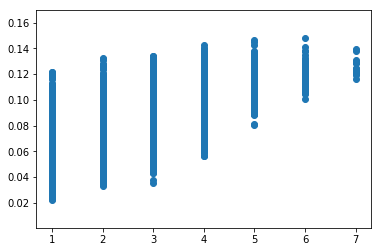

In [159]:
plt.scatter(CIs['grade'], CIs['std_dev'])

In [163]:
grade_avg_std_dev_dict = {}
grade_grouped = CIs.groupby('grade')
for grade, group in grade_grouped:
    grade_avg_std_dev_dict[grade] = group['std_dev'].mean()
    
grade_avg_std_dev_ser = pd.Series(grade_avg_std_dev_dict)

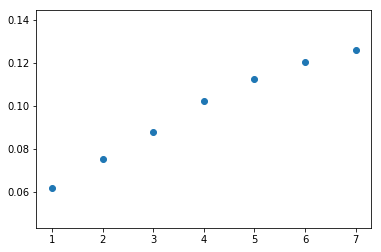

In [166]:
plt.scatter(grade_avg_std_dev_ser.index, grade_avg_std_dev_ser)

## Examining feature importance, making RF with cut features

In [27]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

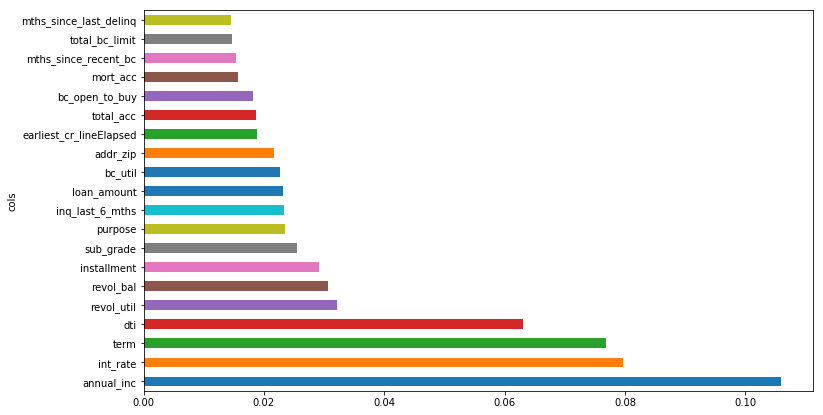

In [28]:
fi = rf_feat_importance(RF, X_train)
plot_fi(fi[:20]);

0.0800152824456


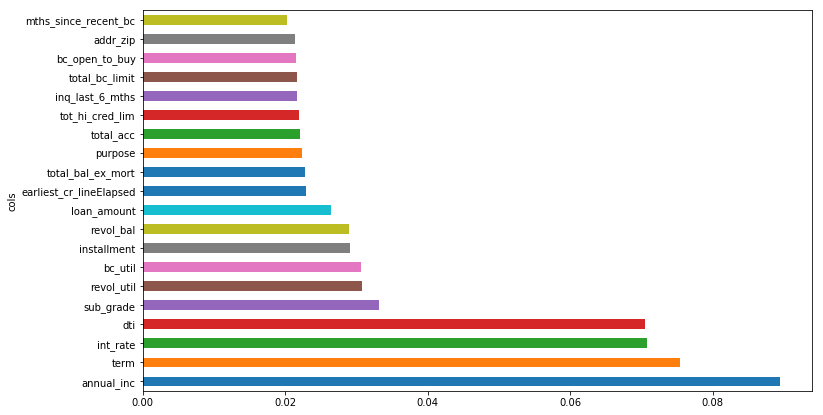

In [36]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = X_train[to_keep].copy()
# X_train, X_valid = split_vals(df_keep, n_trn)
set_rf_samples(20000)
RF_fi = RandomForestRegressor(
    n_estimators=154,
    random_state=0,
    max_features='sqrt',#min(len(to_keep),50),
    min_samples_split=200,
    min_samples_leaf=10,
    n_jobs=-1,
#     oob_score=True,
    bootstrap=True,
    criterion='mse',
)
RF_fi.fit(df_keep, y_train)
print(RF_fi.score(df_keep, y_train))
fi = rf_feat_importance(RF_fi, df_keep)
plot_fi(fi[:20]);

In [39]:
# evaling
yhat_test_RF_fi = RF_fi.predict(X_test[to_keep])
regr_version_RF_fi = '0.2.3'
trials = 30000
port_size = 150
available_loans = 500
results = eval_models(trials, port_size, available_loans, regr_version_RF_fi, X_test=X_test[to_keep], y_test=y_test, default_series=default_series, yhat_test=yhat_test_RF_fi) #regr_std, 

A Jupyter Widget

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [40]:
model_results[results.columns] = results
model_results.to_hdf(store, key='model_results', format='table')
model_results.describe()

discount_rate      baseline                           A                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.056679      0.193342     -0.033183      0.073307   
std                0.018726      0.032075      0.011064      0.021000   
min               -0.138537      0.080000     -0.083743      0.000000   
25%               -0.069253      0.173333     -0.040308      0.060000   
50%               -0.056113      0.193333     -0.032622      0.073333   
75%               -0.043736      0.213333     -0.025429      0.086667   
max                0.014205      0.333333      0.001738      0.166667   

discount_rate         0.2.2                       1.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026968      0.114985     -0.027961      0.114948   
std                0.013915      0.025662      0.013593      0.025896   
min               -0.098831      0.020000     -0.090482      0.026667   
25%               -0.036176      0.100000     -0.036909      0.100000   
50%               -0.026329      0.113333     -0.027437      0.113333   
75%               -0.017245      0.133333     -0.018442      0.133333   
max                0.021321      0.246667      0.016741      0.220000   

discount_rate         3.0.0                       0.2.3                
model                  0.07       pct_def          0.07       pct_def  
count          30000.000000  30000.000000  30000.000000  30000.000000  
mean              -0.025479      0.108049     -0.026701      0.106371  
std                0.013229      0.025091      0.013596      0.024966  
min               -0.095502      0.026667     -0.091041      0.026667  
25%               -0.034188      0.093333     -0.035418      0.086667  
50%               -0.024939      0.106667     -0.026147      0.106667  
75%               -0.016220      0.126667     -0.017287      0.120000  
max                0.017590      0.226667      0.017339      0.213333

In [41]:
model_results.columns

MultiIndex(levels=[['0.2.2', '1.0.1', '3.0.0', 'A', 'baseline', '0.2.3'], [0.07, 'pct_def']],
           labels=[[4, 4, 3, 3, 0, 0, 1, 1, 2, 2, 5, 5], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['discount_rate', 'model'])

In [44]:
model_results.loc[:,['0.2.2', '0.2.3', '3.0.0']].describe()

discount_rate         0.2.2                       3.0.0                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026968      0.114985     -0.025479      0.108049   
std                0.013915      0.025662      0.013229      0.025091   
min               -0.098831      0.020000     -0.095502      0.026667   
25%               -0.036176      0.100000     -0.034188      0.093333   
50%               -0.026329      0.113333     -0.024939      0.106667   
75%               -0.017245      0.133333     -0.016220      0.126667   
max                0.021321      0.246667      0.017590      0.226667   

discount_rate         0.2.3                
model                  0.07       pct_def  
count          30000.000000  30000.000000  
mean              -0.026701      0.106371  
std                0.013596      0.024966  
min               -0.091041      0.026667  
25%               -0.035418      0.086667  
50%               -0.026147      0.106667  
75%               -0.017287      0.120000  
max                0.017339      0.213333

In [48]:
# saving the RF
from sklearn.externals import joblib
joblib.dump(RF_fi, f'{PATH_RF}{regr_version_RF_fi}_{training_type}.pkl') 

['/home/justin/all_data/lendingclub/RF/0.2.3_testing.pkl']

In [54]:
to_keep.to_pickle(f'{data_save_path}to_keep_fi_cols.pkl')

In [55]:
ls {data_save_path}

dl_df_train.fth                RF/                  y_all_train.pkl
dl_ys_train.fth                to_keep_fi_cols.pkl  y_test.pkl
for_proc_df_model_loading.pkl  X_all_train.pkl      y_train.pkl
lendingclub.h5                 X_test.pkl           y_valid.pkl
NN/                            X_train.pkl
oldstuff/                      X_valid.pkl


# NeuralNet with embeddings for categorical (fastai)

In [126]:
# for loading
PATH = f'{datapath}{platform}/'
data_save_path = f'{datapath}{platform}/'
X_train = pd.read_pickle(data_save_path+'X_train.pkl')
y_train = pd.read_pickle(data_save_path+'y_train.pkl')
X_valid = pd.read_pickle(data_save_path+'X_valid.pkl')
y_valid = pd.read_pickle(data_save_path+'y_valid.pkl')
X_test = pd.read_pickle(data_save_path+'X_test.pkl')
y_test = pd.read_pickle(data_save_path+'y_test.pkl')

In [127]:
training_type = 'testing'
data_save_path = f'{datapath}{platform}/'
PATH_NN = f'{datapath}{platform}/NN/'

In [128]:
if training_type == 'testing':
    store.open()
    train = store['train']
    store.close()
    X_train, y_train, nas, embeddings, train_cols_meds, cols, mean_stdev_mapper = proc_df_justin(train, 'y', valid_test = False, do_scale=True)
    X_valid = pd.read_pickle(data_save_path+'X_valid.pkl')
    y_valid = pd.read_pickle(data_save_path+'y_valid.pkl')
    X_test = pd.read_pickle(data_save_path+'X_test.pkl')
    y_test = pd.read_pickle(data_save_path+'y_test.pkl')
    dl_df_train = X_train.append(X_valid)
    val_idxs = np.arange(len(dl_df_train))[-len(X_valid):]
    dl_ys_train = np.append(y_train,y_valid)

In [129]:
bs = 64 * 2**1
cat_sz = embeddings
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
cat_vars = [_[0] for _ in cat_sz]

In [130]:
def asym_loss(y_pred, targ):
    '''asymmetric loss for training the NN.
    Actual (-), pred (+) <- should have highest loss (x more negative, high loss)
    Actual (-), pred (-) <- low loss (x near 0, low loss)
    Actual (+), pred (+) <- low loss (x near 0, low loss)
    Actual (+), pred (-) <- medium-ish loss (x more positive, medium loss)'''
    x = targ-y_pred
    return torch.mean(torch.exp(-x) + x - 1)

In [131]:
# set test_df to X_train when I want predictions of X_train
md = ColumnarModelData.from_data_frame(PATH_NN, val_idxs, dl_df_train, dl_ys_train, cat_vars, bs, test_df=X_test)
n_cont = len(dl_df_train.columns)-len(cat_vars)
print(n_cont)
nn = md.get_learner(emb_szs, n_cont, 0.05, 1, [1000,500,500,250,250], [0.2,0.2,.2,.15,.05])
lr = 1e-3
nn.crit = asym_loss

130


A Jupyter Widget

  3%|▎         | 19/730 [00:01<00:51, 13.69it/s, loss=1.67]


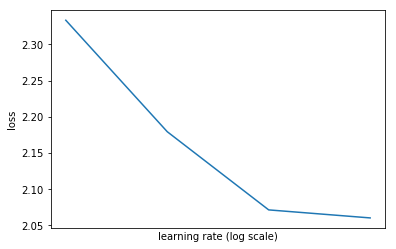

In [132]:
nn.lr_find()
nn.sched.plot()

In [133]:
lr = 1e-4
nn.fit(lr, 5, cycle_len=3, metrics=[asym_loss])

A Jupyter Widget

epoch      trn_loss   val_loss   asym_loss                     
    0      0.108801   0.103287   0.103287  
    1      0.162611   0.099902   0.099902                     
    2      0.090938   0.098929   0.098929                     
    3      0.109877   0.106724   0.106724                     
    4      0.064823   0.055994   0.055994                     
    5      0.064118   0.05366    0.05366                      
    6      0.05942    0.056608   0.056608                     
    7      0.05531    0.046058   0.046058                     
    8      0.055954   0.046432   0.046432                     
    9      0.05067    0.036724   0.036724                     
    10     0.050723   0.034934   0.034934                     
    11     0.048105   0.035274   0.035274                     
    12     0.046971   0.032267   0.032267                     
    13     0.044875   0.034836   0.034836                     
    14     0.044496   0.034774   0.034774                     



[0.034774136, 0.034774137085681021]

In [134]:
lr = 1e-5
nn.fit(lr, 5, cycle_len=3, metrics=[asym_loss])

A Jupyter Widget

epoch      trn_loss   val_loss   asym_loss                    
    0      0.043896   0.031307   0.031307  
    1      0.042258   0.03152    0.03152                      
    2      0.050289   0.03152    0.03152                      
    3      0.042933   0.031125   0.031125                     
    4      0.042399   0.031138   0.031138                     
    5      0.042296   0.031122   0.031122                     
    6      0.042679   0.030654   0.030654                     
    7      0.042667   0.030722   0.030722                     
    8      0.041168   0.030686   0.030686                     
    9      0.041057   0.030518   0.030518                     
    10     0.042988   0.030334   0.030334                     
    11     0.042364   0.03037    0.03037                      
    12     0.048457   0.030337   0.030337                     
    13     0.04249    0.030319   0.030319                     
    14     0.042015   0.030307   0.030307                     



[0.030307185, 0.030307186292388447]

In [135]:
lr = 1e-6
nn.fit(lr, 2, cycle_len=3, metrics=[asym_loss])

A Jupyter Widget

epoch      trn_loss   val_loss   asym_loss                    
    0      0.04128    0.030332   0.030332  
    1      0.040624   0.030321   0.030321                     
    2      0.040809   0.030316   0.030316                     
    3      0.041049   0.030309   0.030309                     
    4      0.040989   0.030309   0.030309                     
    5      0.041262   0.030303   0.030303                     



[0.030303407, 0.030303409871475614]

In [136]:
yhat_test_NN = nn.predict(is_test=True).reshape(-1)
regr_version_NN = '1.0.1'
trials = 30000
port_size = 150
available_loans = 500
results = eval_models(trials, port_size, available_loans, regr_version_NN, X_test=X_test, y_test=y_test, default_series=default_series, yhat_test=yhat_test_NN) #regr_std, 

A Jupyter Widget

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [279]:
model_results[results.columns] = results
model_results.to_hdf(store, key='model_results', format='table')
model_results.describe()

discount_rate      baseline                           A                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.056679      0.193342     -0.033183      0.073307   
std                0.018726      0.032075      0.011064      0.021000   
min               -0.138537      0.080000     -0.083743      0.000000   
25%               -0.069253      0.173333     -0.040308      0.060000   
50%               -0.056113      0.193333     -0.032622      0.073333   
75%               -0.043736      0.213333     -0.025429      0.086667   
max                0.014205      0.333333      0.001738      0.166667   

discount_rate         0.2.2                       1.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026944      0.114903     -0.027961      0.114948   
std                0.013901      0.025692      0.013593      0.025896   
min               -0.091100      0.026667     -0.090482      0.026667   
25%               -0.036045      0.100000     -0.036909      0.100000   
50%               -0.026377      0.113333     -0.027437      0.113333   
75%               -0.017215      0.133333     -0.018442      0.133333   
max                0.020718      0.226667      0.016741      0.220000   

discount_rate         3.0.0                
model                  0.07       pct_def  
count          30000.000000  30000.000000  
mean              -0.024504      0.103901  
std                0.013157      0.024627  
min               -0.092635      0.020000  
25%               -0.033121      0.086667  
50%               -0.023966      0.100000  
75%               -0.015250      0.120000  
max                0.022934      0.220000

# checking nn performance on trunacted features (chosen via RF above)

In [98]:
cat_vars_fi = [col for col in cat_vars if col in to_keep.values]
cat_sz_fi = []
for emb in cat_sz:
    if emb[0] in cat_vars_fi:
        cat_sz_fi.append(emb)
emb_szs_fi = [(c, min(50, (c+1)//2)) for _,c in cat_sz_fi]        

In [114]:
# set test_df to X_train when I want predictions of X_train
md_fi = ColumnarModelData.from_data_frame(PATH_NN, val_idxs, dl_df_train[to_keep], dl_ys_train, cat_vars_fi, bs, test_df=X_test[to_keep])
n_cont = len(dl_df_train[to_keep].columns)-len(cat_vars_fi)
print(n_cont)
nn_fi = md_fi.get_learner(emb_szs_fi, n_cont, 0.05, 1, [1000,500,500,250,250], [0.2,0.2,.2,.15,.05])
lr = 1e-3
nn_fi.crit = asym_loss

38


A Jupyter Widget

 68%|██████▊   | 494/730 [00:13<00:05, 43.78it/s, loss=0.0491]

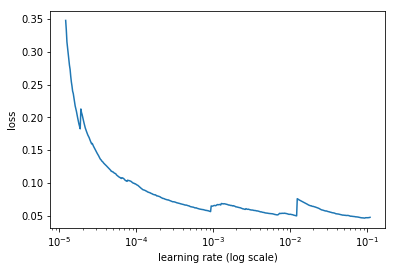

In [115]:
nn_fi.lr_find()
nn_fi.sched.plot()

In [116]:
lr = 5e-4
nn_fi.fit(lr, 2, cycle_len=3, metrics=[asym_loss])

A Jupyter Widget

 23%|██▎       | 170/730 [00:04<00:13, 42.39it/s, loss=0.454] 
epoch      trn_loss   val_loss   asym_loss                    
    0      0.040537   0.029781   0.029781  
    1      0.040267   0.029396   0.029396                     
    2      0.038952   0.029456   0.029456                     
    3      0.038885   0.029332   0.029332                     
    4      0.036951   0.029433   0.029433                     
    5      0.038278   0.029487   0.029487                     



[0.029486779, 0.029486779868813685]

In [117]:
yhat_test_NN_fi = nn_fi.predict(is_test=True).reshape(-1)
regr_version_NN_fi = '1.0.2'
trials = 30000
port_size = 150
available_loans = 500
results = eval_models(trials, port_size, available_loans, regr_version_NN_fi, X_test=X_test[to_keep], y_test=y_test, default_series=default_series, yhat_test=yhat_test_NN_fi) #regr_std, 

A Jupyter Widget

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [118]:
model_results[results.columns] = results
model_results.to_hdf(store, key='model_results', format='table')
model_results.describe()

discount_rate      baseline                           A                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.056679      0.193342     -0.033183      0.073307   
std                0.018726      0.032075      0.011064      0.021000   
min               -0.138537      0.080000     -0.083743      0.000000   
25%               -0.069253      0.173333     -0.040308      0.060000   
50%               -0.056113      0.193333     -0.032622      0.073333   
75%               -0.043736      0.213333     -0.025429      0.086667   
max                0.014205      0.333333      0.001738      0.166667   

discount_rate         0.2.2                       1.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026968      0.114985     -0.027961      0.114948   
std                0.013915      0.025662      0.013593      0.025896   
min               -0.098831      0.020000     -0.090482      0.026667   
25%               -0.036176      0.100000     -0.036909      0.100000   
50%               -0.026329      0.113333     -0.027437      0.113333   
75%               -0.017245      0.133333     -0.018442      0.133333   
max                0.021321      0.246667      0.016741      0.220000   

discount_rate         3.0.0                       0.2.3                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.025479      0.108049     -0.026701      0.106371   
std                0.013229      0.025091      0.013596      0.024966   
min               -0.095502      0.026667     -0.091041      0.026667   
25%               -0.034188      0.093333     -0.035418      0.086667   
50%               -0.024939      0.106667     -0.026147      0.106667   
75%               -0.016220      0.126667     -0.017287      0.120000   
max                0.017590      0.226667      0.017339      0.213333   

discount_rate         1.0.2                
model                  0.07       pct_def  
count          30000.000000  30000.000000  
mean              -0.026930      0.105085  
std                0.013443      0.024953  
min               -0.089601      0.013333  
25%               -0.035606      0.086667  
50%               -0.026273      0.106667  
75%               -0.017554      0.120000  
max                0.017527      0.220000

In [119]:
nn.save(f'{PATH_NN}{regr_version_NN_fi}_{training_type}.pth')

In [120]:
ls {PATH_NN}

1.0.1_all.pth.h5      1.0.2_testing.pth.h5  dl_ys_train.fth  tmp/
1.0.1_testing.pth.h5  dl_df_train.fth       models/


# simple avg of RF and NN

In [137]:
yhat_test = (yhat_test_NN_fi+yhat_test_RF_fi)/2
regr_version = '3.0.1'
trials = 30000
port_size = 150
available_loans = 500
results = eval_models(trials, port_size, available_loans, regr_version, X_test=X_test, y_test=y_test, default_series=default_series, yhat_test=yhat_test) #regr_std, 

A Jupyter Widget

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [138]:
model_results[results.columns] = results
model_results.to_hdf(store, key='model_results', format='table')
model_results.describe()

discount_rate      baseline                           A                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.056679      0.193342     -0.033183      0.073307   
std                0.018726      0.032075      0.011064      0.021000   
min               -0.138537      0.080000     -0.083743      0.000000   
25%               -0.069253      0.173333     -0.040308      0.060000   
50%               -0.056113      0.193333     -0.032622      0.073333   
75%               -0.043736      0.213333     -0.025429      0.086667   
max                0.014205      0.333333      0.001738      0.166667   

discount_rate         0.2.2                       1.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026968      0.114985     -0.027961      0.114948   
std                0.013915      0.025662      0.013593      0.025896   
min               -0.098831      0.020000     -0.090482      0.026667   
25%               -0.036176      0.100000     -0.036909      0.100000   
50%               -0.026329      0.113333     -0.027437      0.113333   
75%               -0.017245      0.133333     -0.018442      0.133333   
max                0.021321      0.246667      0.016741      0.220000   

discount_rate         3.0.0                       0.2.3                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.025479      0.108049     -0.026701      0.106371   
std                0.013229      0.025091      0.013596      0.024966   
min               -0.095502      0.026667     -0.091041      0.026667   
25%               -0.034188      0.093333     -0.035418      0.086667   
50%               -0.024939      0.106667     -0.026147      0.106667   
75%               -0.016220      0.126667     -0.017287      0.120000   
max                0.017590      0.226667      0.017339      0.213333   

discount_rate         1.0.2                       3.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026930      0.105085     -0.026094      0.101666   
std                0.013443      0.024953      0.013203      0.024389   
min               -0.089601      0.013333     -0.087524      0.020000   
25%               -0.035606      0.086667     -0.034744      0.086667   
50%               -0.026273      0.106667     -0.025552      0.100000   
75%               -0.017554      0.120000     -0.016812      0.120000   
max                0.017527      0.220000      0.018948      0.213333   

discount_rate         3.0.2                
model                  0.07       pct_def  
count          30000.000000  30000.000000  
mean              -0.028972      0.108041  
std                0.013526      0.024758  
min               -0.089956      0.020000  
25%               -0.037792      0.093333  
50%               -0.028417      0.106667  
75%               -0.019521      0.126667  
max                0.016818      0.213333

In [139]:
model_results.loc[:,['0.2.2', '0.2.3', '1.0.1', '1.0.2', '3.0.0', '3.0.1']].describe()

discount_rate         0.2.2                       1.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026968      0.114985     -0.027961      0.114948   
std                0.013915      0.025662      0.013593      0.025896   
min               -0.098831      0.020000     -0.090482      0.026667   
25%               -0.036176      0.100000     -0.036909      0.100000   
50%               -0.026329      0.113333     -0.027437      0.113333   
75%               -0.017245      0.133333     -0.018442      0.133333   
max                0.021321      0.246667      0.016741      0.220000   

discount_rate         3.0.0                       0.2.3                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.025479      0.108049     -0.026701      0.106371   
std                0.013229      0.025091      0.013596      0.024966   
min               -0.095502      0.026667     -0.091041      0.026667   
25%               -0.034188      0.093333     -0.035418      0.086667   
50%               -0.024939      0.106667     -0.026147      0.106667   
75%               -0.016220      0.126667     -0.017287      0.120000   
max                0.017590      0.226667      0.017339      0.213333   

discount_rate         1.0.2                       3.0.1                \
model                  0.07       pct_def          0.07       pct_def   
count          30000.000000  30000.000000  30000.000000  30000.000000   
mean              -0.026930      0.105085     -0.026094      0.101666   
std                0.013443      0.024953      0.013203      0.024389   
min               -0.089601      0.013333     -0.087524      0.020000   
25%               -0.035606      0.086667     -0.034744      0.086667   
50%               -0.026273      0.106667     -0.025552      0.100000   
75%               -0.017554      0.120000     -0.016812      0.120000   
max                0.017527      0.220000      0.018948      0.213333   

discount_rate         3.0.2                
model                  0.07       pct_def  
count          30000.000000  30000.000000  
mean              -0.028972      0.108041  
std                0.013526      0.024758  
min               -0.089956      0.020000  
25%               -0.037792      0.093333  
50%               -0.028417      0.106667  
75%               -0.019521      0.126667  
max                0.016818      0.213333

# Full trainable trains

In [7]:
# for saving
PATH_NN = f'{datapath}{platform}/NN/'
PATH_RF = f'{datapath}{platform}/RF/'
data_save_path = f'{datapath}{platform}/'

In [8]:
store.open()
all_train = store['all_train']
store.close()
X_all_train, y_all_train, nas_all_train, embeddings_all_train, train_cols_meds_all_train, cols_all_train, mean_stdev_mapper_all_train = proc_df_justin(all_train, 'y', valid_test = False, do_scale=True)

In [9]:
X_all_train.to_pickle(data_save_path+'X_all_train.pkl')
pd.Series(y_all_train).to_pickle(data_save_path+'y_all_train.pkl')

## Random Forest

In [307]:
# random forest score should be around .08849
set_rf_samples(20000)
RF = RandomForestRegressor(
    n_estimators=154,
    random_state=0,
    max_features=min(X_all_train.shape[1],50),
    min_samples_split=200,
    min_samples_leaf=10,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True,
    criterion='mse',
)
RF.fit(X_all_train,y_all_train)
RF.score(X_all_train,y_all_train)

0.078377579491665572

In [308]:
regr_version_RF = '0.2.2'
training_type = 'all'

In [309]:
# saving the RF
from sklearn.externals import joblib
joblib.dump(RF, f'{PATH_RF}{regr_version_RF}_{training_type}.pkl') 

['/home/justin/all_data/lendingclub/RF/0.2.2_all.pkl']

## NN

In [11]:
training_type = 'all'
data_save_path = f'{datapath}{platform}/'
PATH_NN = f'{datapath}{platform}/NN/'
lcpath = f'{datapath}{platform}/'
storepath = f'{lcpath}{platform}.h5'
store = pd.HDFStore(storepath)
store.close()

In [27]:
def asym_loss(y_pred, targ):
    '''asymmetric loss for training the NN.
    Actual (-), pred (+) <- should have highest loss (x more negative, high loss)
    Actual (-), pred (-) <- low loss (x near 0, low loss)
    Actual (+), pred (+) <- low loss (x near 0, low loss)
    Actual (+), pred (-) <- medium-ish loss (x more positive, medium loss)'''
    x = targ-y_pred
    return torch.mean(torch.exp(-x) + x - 1)

In [28]:
if training_type == 'all':
    store.open()
    train = store['all_train']
    store.close()
    X_train, y_train, nas, embeddings, train_cols_meds, cols, mean_stdev_mapper = proc_df_justin(train, 'y', valid_test = False, do_scale=True)
    dl_df_train = X_train
    val_idxs = [0]
    dl_ys_train = y_train

In [29]:
bs = 64 * 2**1
cat_sz = embeddings
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
cat_vars = [_[0] for _ in cat_sz]

In [51]:
# set test_df to X_train when I want predictions of X_train
md = ColumnarModelData.from_data_frame(PATH_NN, val_idxs, dl_df_train, dl_ys_train, cat_vars, bs, test_df=X_test)
n_cont = len(dl_df_train.columns)-len(cat_vars)
print(n_cont)
nn = md.get_learner(emb_szs, n_cont, 0.05, 1, [1000,500,500,250,250], [0.2,0.2,.2,.15,.05])
lr = 1e-3
nn.crit = asym_loss

209


A Jupyter Widget

 31%|███       | 1818/5884 [00:55<02:08, 31.58it/s, loss=0.0447]

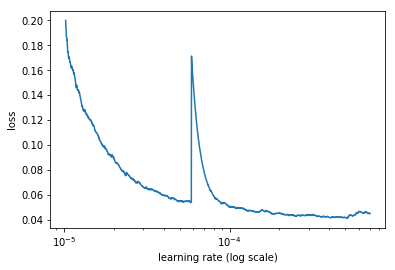

In [52]:
nn.lr_find()
nn.sched.plot()

In [53]:
# looking for a train loss of about .037-.038??
lr = 1e-4
nn.fit(lr, 4, cycle_len=3, metrics=[asym_loss])

A Jupyter Widget

  1%|▏         | 79/5884 [00:04<04:17, 22.56it/s, loss=0.374]   
epoch      trn_loss   val_loss   asym_loss                      
    0      0.041247   0.087606   0.087606  
    1      0.039442   0.08493    0.08493                        
    2      0.039655   0.083813   0.083813                       
    3      0.038198   0.080197   0.080197                       
    4      0.039026   0.072755   0.072755                       
    5      0.03796    0.073815   0.073815                       
    6      0.038389   0.075683   0.075683                       
    7      0.037271   0.075182   0.075182                       
    8      0.037402   0.07162    0.07162                        
    9      0.038008   0.07251    0.07251                        
    10     0.036972   0.070514   0.070514                       
    11     0.036332   0.070543   0.070543                       



[0.070543289, 0.070543289184570312]

In [54]:
nn.save(f'{PATH_NN}{regr_version_NN}_{training_type}.pth')

In [57]:
nn.predict(is_test=False)
# array([[-0.05682]], dtype=float32)
# verify on reload that I can get same answer

array([[-0.05682]], dtype=float32)

# testing loading

In [10]:
for_proc_df_model_loading = (nas_all_train, embeddings_all_train, train_cols_meds_all_train, use_cols, cols_all_train, col_cat_dict, mean_stdev_mapper_all_train, X_all_train.head(), y_all_train[:5], cat_vars, emb_szs)
with open(f'{data_save_path}/for_proc_df_model_loading.pkl', 'wb') as handle:
    pickle.dump(for_proc_df_model_loading, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'use_cols' is not defined

## RF

In [15]:
regr_version_RF = '0.2.2'
RF = joblib.load(f'{PATH_RF}{regr_version_RF}_{training_type}.pkl') 
RF.predict(X_all_train)
RF.score(X_all_train, y_all_train)

0.078377579491665572

## NN

In [91]:
with open(f'{data_save_path}/for_proc_df_model_loading.pkl', 'rb') as handle:
    nas_all_train, embeddings_all_train, train_cols_meds_all_train, cols_all_train, mean_stdev_mapper_all_train, dl_df_train, dl_ys_train, cat_vars, emb_szs = pickle.load(handle)
    
val_idxs = [0]
bs = 64
X_test = None
regr_version_NN = '1.0.1'
training_type = 'all'

In [92]:
md = ColumnarModelData.from_data_frame(PATH_NN, val_idxs, dl_df_train, dl_ys_train, cat_vars, bs, test_df=X_test)
n_cont = len(dl_df_train.columns)-len(cat_vars)
print(n_cont)
nn = md.get_learner(emb_szs, n_cont, 0.05, 1, [1000,500,500,250,250], [0.2,0.2,.2,.15,.05])

209


In [102]:
dl_df_train

,acc_now_delinq,acc_open_past_24_mths,addr_state,addr_zip,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,...,earliest_cr_lineWeek_na,earliest_cr_lineDay_na,earliest_cr_lineDayofweek_na,earliest_cr_lineDayofyear_na,sec_app_earliest_cr_lineYear_na,sec_app_earliest_cr_lineMonth_na,sec_app_earliest_cr_lineWeek_na,sec_app_earliest_cr_lineDay_na,sec_app_earliest_cr_lineDayofweek_na,sec_app_earliest_cr_lineDayofyear_na
id,,,,,,,,,,,,,,,,,,,,,
36805548,-0.064072,0.738009,1,1,0.094443,-0.271991,-0.149522,2,-0.245948,-0.123736,...,False,False,False,False,True,True,True,True,True,True
38098114,-0.064072,0.099394,2,2,0.094443,0.047120,-0.149522,2,1.002750,0.008937,...,False,False,False,False,True,True,True,True,True,True
37822187,-0.064072,1.057316,3,3,0.094443,-0.096480,-0.149522,2,-0.634981,-0.199855,...,False,False,False,False,True,True,True,True,True,True
37662224,-0.064072,0.418701,4,4,0.094443,-0.399636,-0.149522,2,-0.472340,-0.624329,...,False,False,False,False,True,True,True,True,True,True
37842129,-0.064072,-0.219914,5,5,0.094443,-0.179449,-0.149522,2,-0.572337,-0.624880,...,False,False,False,False,True,True,True,True,True,True


In [64]:
nn.load(f'{PATH_NN}{regr_version_NN}_{training_type}.pth')

In [67]:
nn.predict(is_test=False)
#array([[-0.05682]], dtype=float32)
# verify on reload that I can get same answer

array([[-0.05682]], dtype=float32)

# examining RF

In [ ]:
regr_version_RF = '0.2.2'
RF = joblib.load(f'{PATH_RF}{regr_version_RF}_{training_type}.pkl') 
RF.predict(X_all_train)
RF.score(X_all_train, y_all_train)
def get_preds(t): return t.predict(X_all_train)
%time preds = np.stack(parallel_trees(RF, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

In [20]:
np.mean(preds[:,:]), np.std(preds[:,:])

(-0.054509904581739911, 0.10217965900096464)

In [22]:
preds.shape

(154, 753098)

In [28]:
CIs = np.array((np.mean(preds, axis=0), np.std(preds,axis=0)))

In [32]:
np.mean(preds, axis=0)

array([-0.03282, -0.0587 , -0.05605, ..., -0.2261 , -0.2171 , -0.00294])

In [38]:
maxs = CIs[0]+ 2*CIs[1]
mins = CIs[0]- 2*CIs[1]

In [40]:
CI_df = pd.DataFrame([maxs, mins]).T

In [41]:
CI_df.columns = ['max', 'min']

In [43]:
CI_df[CI_df['min'] > -.05]

,max,min
654,0.025738,-0.044934
859,0.029042,-0.049060
1646,0.048784,-0.049229
2428,0.027179,-0.049406
2513,0.058693,-0.048560
3034,0.035510,-0.046088
3149,0.019052,-0.039626
3180,0.021883,-0.049377
3521,0.041371,-0.037322
3643,0.032862,-0.047967


In [45]:
# feature importance
fi = rf_feat_importance(RF, X_all_train); fi[:20]
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

,cols,imp
89,term,0.068900
16,dti,0.064979
87,sub_grade,0.058455
29,int_rate,0.051032
5,annual_inc,0.027688
1,acc_open_past_24_mths,0.027539
21,grade,0.027299
92,tot_hi_cred_lim,0.026911
8,avg_cur_bal,0.024892
32,loan_amount,0.019515


63

0.0808269824291


In [58]:
RF.score?

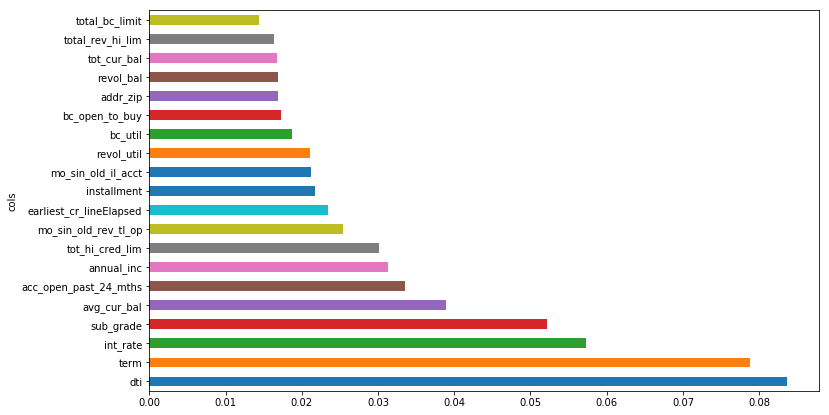